## Setting Up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import zipfile
import cdsapi
import numpy as np
import glob
import xarray as xr
import massbalancemachine as mbm

from scripts.config_FR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

## Download monthly ERA5-Land variables:

To download ERA5-Land data you need to configure your API client first. For this, follow these instructions: https://forum.ecmwf.int/t/step-by-step-instructions-on-how-to-download-data-using-new-climate-data-store-beta-cds-beta/3743. 

To summarize instructions: 
- Your existing CDS credentials will not work in CDS-Beta, you need to have an ECMWF account - register one here: https://www.ecmwf.int/. 
- Once you have set up an account, make sure that you accepted licences in the Download form of the product page: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=download. 
- Make sure that you are logged in ECMWF then navigate to the CDSAPI setup page to copy the content for your .cdsapirc file: https://cds.climate.copernicus.eu/how-to-api. 

Once this is set up, you should be able to download the ERA5-Land data using our script. 

In [ ]:
RUN = True
if RUN:
    os.makedirs(cfg.dataPath + path_ERA5_raw, exist_ok=True)
    c = cdsapi.Client()

    # climate variables
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            'product_type': ['monthly_averaged_reanalysis'],
            'variable': [
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation',
            ],
            'year': [
                '1950',
                '1951',
                '1952',
                '1953',
                '1954',
                '1955',
                '1956',
                '1957',
                '1958',
                '1959',
                '1960',
                '1961',
                '1962',
                '1963',
                '1964',
                '1965',
                '1966',
                '1967',
                '1968',
                '1969',
                '1970',
                '1971',
                '1972',
                '1973',
                '1974',
                '1975',
                '1976',
                '1977',
                '1978',
                '1979',
                '1980',
                '1981',
                '1982',
                '1983',
                '1984',
                '1985',
                '1986',
                '1987',
                '1988',
                '1989',
                '1990',
                '1991',
                '1992',
                '1993',
                '1994',
                '1995',
                '1996',
                '1997',
                '1998',
                '1999',
                '2000',
                '2001',
                '2002',
                '2003',
                '2004',
                '2005',
                '2006',
                '2007',
                '2008',
                '2009',
                '2010',
                '2011',
                '2012',
                '2013',
                '2014',
                '2015',
                '2016',
                '2017',
                '2018',
                '2019',
                '2020',
                '2021',
                '2022',
                '2023',
                '2024',
            ],
            'month': [
                '01',
                '02',
                '03',
                '04',
                '05',
                '06',
                '07',
                '08',
                '09',
                '10',
                '11',
                '12',
            ],
            'time': ['00:00'],
            "data_format":
            "netcdf",
            "download_format":
            "zip",
            'area': [   # Alps
                49.1,   # North
                2,      # West
                43,     # South
                18,     # East
            ],
        }, cfg.dataPath + path_ERA5_raw + 'download.netcdf.zip')
    with zipfile.ZipFile(cfg.dataPath + path_ERA5_raw + 'download.netcdf.zip', 'r') as zip:
        zip.extractall(cfg.dataPath + path_ERA5_raw)
    
    # geopot from era5-land reanalysis directly (new product with better resolution)
    # download it separately so that the pipeline still works
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            "variable": ["geopotential"],
            "data_format": "netcdf",
            "download_format": "zip",
            'area': [   # Alps
                49.1,   # North
                2,      # West
                43,     # South
                18,     # East
            ],
        }, cfg.dataPath + path_ERA5_raw + 'download_geopot.netcdf.zip')
    with zipfile.ZipFile(cfg.dataPath + path_ERA5_raw + 'download_geopot.netcdf.zip', 'r') as zip:
        zip.extractall(cfg.dataPath + path_ERA5_raw)

2025-06-09 20:05:42,177 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-09 20:05:42,516 INFO Request ID is 252771a8-d8ca-4d2c-9ff1-c046bf8416e5
2025-06-09 20:05:42,709 INFO status has been updated to accepted
2025-06-09 20:05:56,555 INFO status has been updated to running
2025-06-09 20:37:13,566 INFO status has been updated to successful


97369e5e9be19ed5ddda3a9307346bce.zip:   0%|          | 0.00/235M [00:00<?, ?B/s]

2025-06-09 20:42:15,004 INFO Request ID is 6577c226-e5f4-4dc5-afd0-4de5f0655faa
2025-06-09 20:42:15,106 INFO status has been updated to accepted
2025-06-09 20:42:37,190 INFO status has been updated to running
2025-06-09 20:42:50,552 INFO status has been updated to successful


65f39c07125a437e83ffd016684f949e.zip:   0%|          | 0.00/88.0k [00:00<?, ?B/s]

In [3]:
! ls "{cfg.dataPath + path_ERA5_raw}"

era5_geopotential_pressure_Alps.nc  era5_monthly_averaged_data_Alps.nc


In [ ]:
# Correct era5 data
dc = xr.open_dataset(cfg.dataPath + path_ERA5_raw + 'data_stream-moda.nc')
dc2 = dc.rename(
    {'valid_time': 'time'}
)  # Coordinates have changed recently in the API, this is to keep compatibility with our code

# delete file if already exists
if os.path.exists(cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc'):
    os.remove(cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc')
dc2.to_netcdf(cfg.dataPath + path_ERA5_raw + "era5_monthly_averaged_data_Alps.nc")

# change name of geopotential file: 
dc = xr.open_dataset(cfg.dataPath + path_ERA5_raw + 'geo.area-subset.49.1.18.43.2.nc')
# delete file if already exists
if os.path.exists(cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'):
    os.remove(cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc')
dc.to_netcdf(cfg.dataPath + path_ERA5_raw + "era5_geopotential_pressure_Alps.nc")

# delete old files
os.remove(cfg.dataPath + path_ERA5_raw + 'download.netcdf.zip')
os.remove(cfg.dataPath + path_ERA5_raw + 'data_stream-moda.nc')
os.remove(cfg.dataPath + path_ERA5_raw+'download_geopot.netcdf.zip')
os.remove(cfg.dataPath + path_ERA5_raw+'geo.area-subset.49.1.18.43.2.nc')

In [ ]:
! ls "{cfg.dataPath + path_ERA5_raw}"

era5_geopotential_pressure_Alps.nc  era5_monthly_averaged_data_Alps.nc


### Check geopotential data:

In [ ]:
geopot_era5 = xr.open_dataset(cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc')
display(geopot_era5)

display(xr.open_dataset(cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc'))

<xarray.Dataset> Size: 81kB
Dimensions:    (time: 1, latitude: 62, longitude: 161)
Coordinates:
  * longitude  (longitude) float32 644B 2.0 2.1 2.2 2.3 ... 17.7 17.8 17.9 18.0
  * latitude   (latitude) float32 248B 49.1 49.0 48.9 48.8 ... 43.2 43.1 43.0
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 80kB ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

<xarray.Dataset> Size: 503MB
Dimensions:    (time: 900, latitude: 62, longitude: 161)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-12-01
  * latitude   (latitude) float64 496B 49.1 49.0 48.9 48.8 ... 43.2 43.1 43.0
  * longitude  (longitude) float64 1kB 2.0 2.1 2.2 2.3 ... 17.7 17.8 17.9 18.0
    expver     (time) <U4 14kB ...
Data variables: (12/14)
    u10        (time, latitude, longitude) float32 36MB ...
    v10        (time, latitude, longitude) float32 36MB ...
    t2m        (time, latitude, longitude) float32 36MB ...
    fal        (time, latitude, longitude) float32 36MB ...
    snowc      (time, latitude, longitude) float32 36MB ...
    rsn        (time, latitude, longitude) float32 36MB ...
    ...         ...
    smlt       (time, latitude, longitude) float32 36MB ...
    slhf       (time, latitude, longitude) float32 36MB ...
    str        (time, latitude, longitude) float32 36MB ...
    sshf       (time, latitude, longitude) float32 36MB ...
    ssrd       (time, latitude, longitude) float32 36MB ...
    tp         (time, latitude, longitude) float32 36MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-09T18:32 GRIB to CDM+CF via cfgrib-0.9.1...

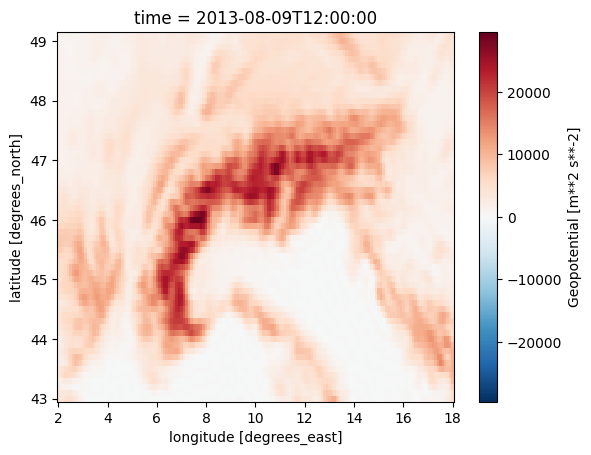

In [10]:
# plot geopot new
geopot_era5.z.plot()